In [1]:
import numpy as np
import pandas as pd
import itertools
import pprint
from math import factorial
from IPython.display import display

## MTA based on ordered channel sequences

In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# use GPU to speed up if available
is_cuda = torch.cuda.is_available()
device = torch.device("cuda") if is_cuda else torch.device("cpu")

### Data: Criteo Attribution Modeling

download url: https://ailab.criteo.com/criteo-attribution-modeling-bidding-dataset/

In [4]:
df0 = pd.read_csv('input/criteo_attribution_dataset.tsv.gz', sep='\t', compression='gzip')

### Batch LSTM & LSTM-A


Modeling ref: https://github.com/ikatsov/tensor-house/blob/master/promotions/channel-attribution-lstm.ipynb

Pytorch example: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html 

#### Prepare Data

In [5]:
np.random.seed(996)

# data preparation
# ref https://github.com/ikatsov/tensor-house/blob/master/promotions/channel-attribution-lstm.ipynb
def add_derived_columns(df):
    """add journey_id, normalize some columns"""
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    min_max_scaler = MinMaxScaler()
    
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext


def filter_journeys_by_length(df, min_touchpoints):
    """filter journeys with some touchpoints or above"""
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

    
def sample_campaigns(df, n_campaigns):
    """sample campaigns"""
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]


def balance_conversions(df, n_samples=40_000):
    """balance journey count on conversion 1/0 groups"""
    jid_converted = df[df.conversion==1]['jid'].unique()
    jid_unconverted = df[df.conversion==0]['jid'].unique()
    jid_sampled = np.concatenate((np.random.choice(jid_converted, n_samples, replace=False),
        np.random.choice(jid_unconverted, n_samples, replace=False)), axis=None)
    return df[lambda x: x['jid'].isin(jid_sampled)]


def map_one_hot(df, column_names, result_column_name):
    """map some columns into dummy var list of single columns"""
    mapper = {} 
    
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    return df_ext


n_campaigns = 400
df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3).sort_values(by=['timestamp_norm'])
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [6]:
# free ram
del df1, df2, df3, df4, df5

#### Create features for all touch points

In [31]:
# I used as less features as possible to learn from touch points only
def features_for_lstm(df, max_touchpoints):
    df_proj = df[[
        'jid', 
        'campaigns', 
        # 'cats', 
        'click', 
        # 'cost', 
        'time_since_last_click_norm', 
        # 'timestamp_norm', 
        'conversion'
    ]]    
    x, y = [], []
    
    for j, d in df_proj.groupby(['jid']):
        # concatenate features for each impression
        journey_matrix = np.apply_along_axis(np.hstack, 1, d.values[:, 1:-1])
        # sort impressions by timestamp
        journey_matrix = journey_matrix[journey_matrix[:, 5].argsort()]
        n_touchpoints = len(journey_matrix)
        padded_journey = []
        
        # pad 0s to max_touchpoints for each journey
        if (n_touchpoints >= max_touchpoints):
            padded_journey = journey_matrix[0:max_touchpoints]
        else:
            padded_journey = np.pad(
                journey_matrix, 
                ((0, max_touchpoints-n_touchpoints), (0, 0)), 
                'constant', 
                constant_values=(0)
            )
            
        x.append(padded_journey)
        y.append(np.max(d.values[:, -1]))
        
    return np.stack(x), np.array(y)


x, y = features_for_lstm(df6, max_touchpoints = 15)

In [32]:
x.shape

(80000, 15, 402)

In [33]:
# train test split
train_x, val_x, train_y, val_y = \
    train_test_split(x, y, test_size = 0.20, random_state = 1)

# create Dataloader
# https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-double-but-got-scalar-type-float-for-argument-2-weight/38961/14
batch_size = 128
train_data = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_data = TensorDataset(torch.from_numpy(val_x).float(), torch.from_numpy(val_y).float())
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)

#### Dev step-by-step

In [10]:
# x0, y0 = next(iter(train_loader))
# print(f"x0 shape: {x0.shape}")
# print(f"y0 shape: {y0.shape}")

In [11]:
# # dev process for basic lstm using last hidden state
# hidden_size = 64
# embed_size = 128
# num_layers = 2

# #embed
# embed_1 = nn.Linear(x0.shape[2], embed_size)
# x1 = embed_1(x0) # [batch_size, seq_length, embed_size]
# # lstm
# lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=.2, batch_first=True)
# # lstm out: [batch_size, seq_length, hidden_size] 
# # hx, cx: [num_layer, batch_size, hidden_size]
# lstm_out, (hx, cx) = lstm(x1)
# # linear
# fc_1 = nn.Linear(hidden_size, 1)
# x2 = fc_1(hx[-1]) # [batch_size, 1]
# # sigmoid
# sigmoid = nn.Sigmoid()
# x3 = sigmoid(x2) # [batch_size, 1]
# x4 = x3.flatten() # [batch_size]

In [12]:
# # dev process for lstm-a using all hidden state
# # suppose output contains hidden states h_t of all t of last layer!
# hidden_size = 64
# embed_size = 128
# num_layers = 2

# # --- attention in CS224n seq2seq model
# # # embed
# # embed_1 = nn.Linear(x0.shape[2], embed_size)
# # x1 = embed_1(x0) # [batch_size, seq_length, embed_size]
# # # lstm
# # lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=.2, batch_first=True)
# # # lstm out: [batch_size, seq_length, hidden_size] 
# # # hx, cx: [num_layer, batch_size, hidden_size]
# # lstm_out, (hx, cx) = lstm(x1) 
# # # last hidden of last layer
# # h = hx[-1].unsqueeze(2) # [batch_size, seq_length, 1]
# # # attention weights
# # attn_weights = torch.bmm(lstm_out, h) # [batch_size, seq_length, 1]
# # attn = F.softmax(attn_weights.squeeze(), 1) # [batch_size, seq_length]
# # # weighted hidden states
# # attn_out = torch.bmm(attn.unsqueeze(1), lstm_out).squeeze(1) # [batch_size, hidden_size]
# # # transpose and predict
# # fc_1 = nn.Linear(hidden_size, 1) 
# # out = fc_1(attn_out) # [batch_size, 1]
# # sigmoid = nn.Sigmoid()
# # output = sigmoid(out).squeeze() # [batch_size]

# # --- attention in paper
# # embed
# x1 = embed_1(x0) # [batch_size, seq_length, embed_size]
# # lstm
# lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=.2, batch_first=True)
# # lstm out: [batch_size, seq_length, hidden_size] 
# # hx, cx: [num_layer, batch_size, hidden_size]
# lstm_out, (hx, cx) = lstm(x1)
# # linear
# fc_1 = nn.Linear(hidden_size, 1) 
# attn_weights = fc_1(lstm_out) # [batch_size, seq_length, 1]
# # tan
# attn_weights = nn.Tanh()(attn_weights) # [batch_size, seq_length, 1]
# # softmax
# attn = nn.Softmax(1)(attn_weights.squeeze()) # [batch_size, seq_length]
# # weighted hidden states
# attn_out = torch.bmm(attn.unsqueeze(1), lstm_out).squeeze(1) # [batch_size, hidden_size]
# fc_2 = nn.Linear(hidden_size, 1) 
# out = fc_2(attn_out) # [batch_size, 1]
# output = nn.Sigmoid()(out).squeeze() # [batch_size]

#### Models: LSTM & LSTM-A

In [17]:
class MTABatch0(nn.Module):
    def __init__(self, batch_size, input_size, embed_size, hidden_size, num_layers=2):
        super(MTABatch0, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed_1 = nn.Linear(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=.2, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs, states):
        x1 = self.embed_1(inputs) # [batch_size, seq_length, embed_size]
        output, (hx, cx) = lstm(x1)
        x2 = self.fc_1(hx) # [batch_size, 1]
        x3 = self.sigmoid(x2[-1]) # [batch_size, 1]
        x4 = x3.flatten() # [batch_size]
        return x4

    def init_states(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size), 
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

In [18]:
class MTABatch1(nn.Module):
    def __init__(self, batch_size, input_size, embed_size, hidden_size, num_layers=2):
        super(MTABatch1, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed_1 = nn.Linear(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=.2, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 1)
        self.fc_2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs, states):
        # embed
        x1 = self.embed_1(inputs) # [batch_size, seq_length, embed_size]
        # lstm
        # lstm out: [batch_size, seq_length, hidden_size] 
        # hx, cx: [num_layer, batch_size, hidden_size]
        lstm_out, (hx, cx) = self.lstm(x1)
        # linear
        attn_weights = self.fc_1(lstm_out) # [batch_size, seq_length, 1]
        # tan
        attn_weights = nn.Tanh()(attn_weights) # [batch_size, seq_length, 1]
        # softmax
        attn = nn.Softmax(1)(attn_weights.squeeze(2)) # [batch_size, seq_length]
        # weighted hidden states
        attn_out = torch.bmm(attn.unsqueeze(1), lstm_out).squeeze(1) # [batch_size, hidden_size]
        out = self.fc_2(attn_out) # [batch_size, 1]
        output = self.sigmoid(out).squeeze(1) # [batch_size]
        return output, attn

    def init_states(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size), 
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

#### Train in Batch

In [34]:
# create model
input_size = train_x.shape[-1]
hidden_size = 64
embed_size = 128

model = MTABatch1(batch_size=batch_size, input_size=input_size, embed_size=embed_size, hidden_size=hidden_size)
(h0, c0) = model.init_states()
loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.02)

In [35]:
def train_one_epoch(epoch_index):
    running_loss, running_acc = 0., 0.
    avg_loss, avg_acc = 0., 0.

    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs, _ = model(inputs, (h0, c0))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        # get accuracy
        acc = ((outputs>0.5).to(torch.float)==labels).to(torch.float).mean()
        running_acc += acc

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            avg_loss = running_loss / 100 # loss per batch
            avg_acc = running_acc / (i + 1)
            print(f'batch {i + 1} loss: {avg_loss:.4f}')
            running_loss = 0.

    return avg_loss, avg_acc

In [36]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
EPOCHS = 2
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_acc = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    running_vacc = 0.0
    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        voutputs, _ = model(vinputs, (h0, c0))
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        # get accuracy
        acc = ((voutputs>0.5).to(torch.float)==vlabels).to(torch.float).mean()
        running_vacc += acc

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)
    print(f'train loss {avg_loss:.4f}, train acc {avg_acc:.4f} ... valid loss {avg_vloss:.4f}, valid acc {avg_vacc:.4f}')

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}.model'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
batch 100 loss: 0.3448
batch 200 loss: 0.1682
batch 300 loss: 0.1603
batch 400 loss: 0.1582
batch 500 loss: 0.1544
train loss 0.1544, train acc 0.9369 ... valid loss 0.1409, valid acc 0.9558
EPOCH 2:
batch 100 loss: 0.1477
batch 200 loss: 0.1364
batch 300 loss: 0.1440
batch 400 loss: 0.1566
batch 500 loss: 0.1482
train loss 0.1482, train acc 0.9532 ... valid loss 0.1367, valid acc 0.9564


### Attribution with LTA and LSTM-A

In [37]:
input_size = x.shape[-1]
hidden_size = 64
embed_size = 128
batch_size_f = 1

# loader for all data
full_data = TensorDataset(torch.from_numpy(x).float(), torch.from_numpy(y).float())
full_loader = DataLoader(full_data, shuffle=False, batch_size=batch_size_f)

In [38]:
# load trained model with batch_size = 1
model_state_path = 'model_20220712_180708_1.model'

model_f = MTABatch1(batch_size=batch_size_f, input_size=input_size, embed_size=embed_size, hidden_size=hidden_size)
(h0, c0) = model_f.init_states()
model_f.load_state_dict(torch.load(model_state_path))
model_f.eval()

MTABatch1(
  (embed_1): Linear(in_features=402, out_features=128, bias=True)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc_1): Linear(in_features=64, out_features=1, bias=True)
  (fc_2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [47]:
# channel counts and contributions
contrib_lstm_a = np.zeros(n_campaigns)
contrib_lta = np.zeros(n_campaigns)
campaign_freq = np.ones(n_campaigns)

for i, data in enumerate(full_loader):
    _x, _y = data
    _, attn = model_f(_x, (h0, c0))
    last_channel_id = None
    
    for step, var in enumerate(_x):
        
        
        # lstm-a
        if _x[step].sum() > 0:
            channel_id = np.argmax(_x[step][0:n_campaigns]) # index of campaign
            attn_value = attn[0, step] # normalized attention
            campaign_freq[channel_id] += 1
            last_channel_id = channel_id
            if _y > 0:
                contrib_lstm_a[channel_id] += attn_value
        
    # lta
    if _y > 0:
        contrib_lta[last_channel_id] += 1

In [53]:
# the padded steps have positive attention weights, so the sum of rest are smaller than conversions
contrib_lstm_a_norm = sum(contrib_lta) / sum(contrib_lstm_a) * contrib_lstm_a

In [54]:
# conversion rates under different attribution methods
attr_lstm_a_norm = contrib_lstm_a_norm / campaign_freq
attr_lstm_a = contrib_lstm_a / campaign_freq
attr_lta = contrib_lta / campaign_freq

In [55]:
campaign_idx = range(200, 240)

In [56]:
import plotly.express as px
import plotly.graph_objects as go

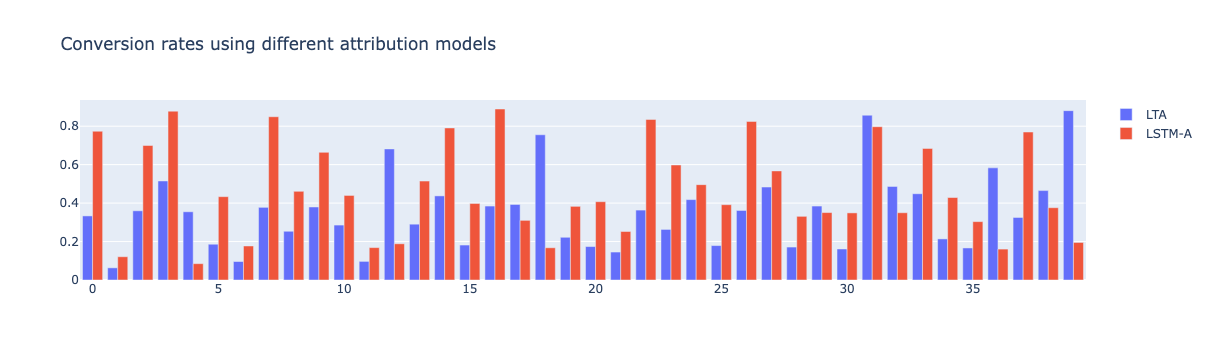

In [57]:
fig = go.Figure()
fig.add_trace(go.Bar(x=np.arange(len(campaign_idx)), y=attr_lta[campaign_idx], name='LTA'))
fig.add_trace(go.Bar(x=np.arange(len(campaign_idx)), y=attr_lstm_a_norm[campaign_idx], name='LSTM-A'))
fig.update_layout(title='Conversion rates using different attribution models')
fig.show()